# Liver Segmentation Using MONAI

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import glob
import pandas as pd
import pytorch_lightning
import torch
from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, Resized, LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance

monai.config.print_config()

MONAI version: 0.3.0rc3
Python version: 3.8.3 (default, May 19 2020, 18:47:26)  [GCC 7.3.0]
Numpy version: 1.19.5
Pytorch version: 1.5.1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.0
scikit-image version: 0.17.2
Pillow version: 7.2.0
Tensorboard version: 2.2.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.6.0a0+35d732a
ITK version: 5.1.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Verify System Setup
Check torch and CUDA on the system.

In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [5]:
INPUT_PATH = 'MasterVolumetryNetExperiment_n470.csv'

df = pd.read_csv(INPUT_PATH, index_col=False)
del(df['Unnamed: 0'])
df.rename(columns={'PV':'IMAGE', 'LIVER_SEGM':'SEGM'}, inplace=True)

for idx, row in df.iterrows():
    df.loc[idx, 'ACCESSION_ID'] = str(row['ACCESSION_ID'])

df

,ACCESSION_ID,IMAGE,SEGM,DATA_SPLIT
0,11341108,/tensor5/data1/LIVER/Yale/imaging/nifti/113411...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train
1,E102874387,/tensor5/data1/LIVER/Yale/imaging/nifti/E10287...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train
2,E106640331,/tensor5/data1/LIVER/Yale/imaging/nifti/E10664...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train
3,E103349034,/tensor5/data1/LIVER/Yale/imaging/nifti/E10334...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train
4,E102514802,/tensor5/data1/LIVER/Yale/imaging/nifti/E10251...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train
...,...,...,...,...
465,E104136816,/tensor5/data1/LIVER/Yale/imaging/nifti/E10413...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Test
466,E101753253,/tensor5/data1/LIVER/Yale/imaging/nifti/E10175...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Test
467,E104504259,/home/mgross/MoSegsRecurrenceProject/E10450425...,/home/mgross/MoSegsRecurrenceProject/E10450425...,Test
468,E105131331,/tensor5/data1/LIVER/Yale/imaging/nifti/E10513...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Test


In [6]:
df_train = df[df['DATA_SPLIT'] == 'Train']
df_val   = df[df['DATA_SPLIT'] == 'Val']
df_test  = df[df['DATA_SPLIT'] == 'Test']

In [7]:
## Load External Test Set

segm_path = 'Paris/man_liver_segms/*_PV_LIVER-label.nii.gz'
segm_paths = glob.glob(segm_path)

paris_accs = [i.split('/')[-1].split('_')[0] for i in segm_paths]
img_paths = ['Paris/' + str(i) + '/' + str(i) + '_PV.nii.gz' for i in paris_accs]

df_paris = pd.DataFrame({'ACCESSION_ID': paris_accs, 'IMAGE' : img_paths, 'SEGM' : segm_paths})
df_paris

,ACCESSION_ID,IMAGE,SEGM
0,00010,/tensor5/data1/mgross/Liver/Paris/00010/00010_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
1,00023,/tensor5/data1/mgross/Liver/Paris/00023/00023_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
2,00004,/tensor5/data1/mgross/Liver/Paris/00004/00004_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
3,00017,/tensor5/data1/mgross/Liver/Paris/00017/00017_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
4,00040,/tensor5/data1/mgross/Liver/Paris/00040/00040_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
5,00011,/tensor5/data1/mgross/Liver/Paris/00011/00011_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
6,00022,/tensor5/data1/mgross/Liver/Paris/00022/00022_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
7,00018,/tensor5/data1/mgross/Liver/Paris/00018/00018_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
8,00012,/tensor5/data1/mgross/Liver/Paris/00012/00012_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
9,00006,/tensor5/data1/mgross/Liver/Paris/00006/00006_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...


In [8]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')
paris_test_data_dict = df_paris.to_dict('records')

print('Number of training files: ', len(train_data_dict))
print('Number of validation files: ', len(val_data_dict))
print('Number of testing files: ', len(test_data_dict))
print('Number of external testing files (Paris): ', len(paris_test_data_dict))



Number of training files:  329
Number of validation files:  70
Number of testing files:  71
Number of external testing files (Paris):  20


In [9]:
def get_x_spacing(x):
    nii = nib.load(x)
    spacing = np.array(nii.header.get_zooms())
    x_spacing = spacing[0]
    return x_spacing

def get_y_spacing(x):
    nii = nib.load(x)
    spacing = np.array(nii.header.get_zooms())
    y_spacing = spacing[1]
    return y_spacing

def get_z_spacing(x):
    nii = nib.load(x)
    spacing = np.array(nii.header.get_zooms())
    z_spacing = spacing[2]
    return z_spacing

x_spacings = list()
y_spacings = list()
z_spacings = list()

for i in df.IMAGE:
    x_spacings.append(get_x_spacing(i))
    y_spacings.append(get_y_spacing(i))
    z_spacings.append(get_z_spacing(i))

    
df_spacings = df.copy()
df_spacings['x_spacing'] = x_spacings
df_spacings['y_spacing'] = y_spacings
df_spacings['z_spacing'] = z_spacings


df_spacings.describe()

,x_spacing,y_spacing,z_spacing
count,470.000000,470.000000,470.000000
mean,1.353218,1.353218,2.972654
std,0.457268,0.457268,0.458212
min,0.507800,0.507800,1.400000
25%,0.968572,0.968572,3.000000
50%,1.312500,1.312500,3.000000
75%,1.988281,1.988281,3.000000
max,2.000000,2.000000,5.000000


## Setup Input Transformations

In [10]:
SPACING = (2.0,2.0,2.0)

train_transforms = Compose([
    LoadNiftid(keys=['IMAGE', 'SEGM']),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['IMAGE', 'SEGM'], spatial_size=(64,64,32), mode=('reflect','reflect'), ),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['IMAGE', 'SEGM'], label_key='SEGM', spatial_size=(64,64,32), pos=3, neg=1, num_samples=2),
    ToTensord(keys=['IMAGE', 'SEGM'])
])

val_transforms = Compose([
    LoadNiftid(keys=['IMAGE', 'SEGM']),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE', 'SEGM'])
])

test_transforms = Compose([
    LoadNiftid(keys=['IMAGE', 'SEGM']),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE', 'SEGM'])
])



## Check Input Data

torch.Size([1, 1, 200, 178, 132])
image shape: torch.Size([200, 178, 132]), label shape: torch.Size([200, 178, 132])
image mean: 0.09921552240848541


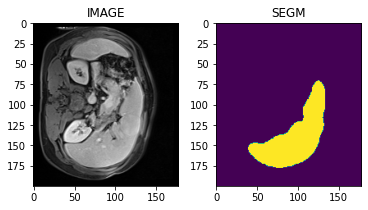

In [11]:
#check_ds = monai.data.Dataset(data=train_data_dict[:250], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[:1], transform=val_transforms)
check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)





check_loader = DataLoader(check_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)

num_display = 20
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image, label = (check_data['IMAGE'][i][0], check_data['SEGM'][i][0])
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//2
    
    plt.figure('check', (6, 3))
    plt.subplot(1, 2, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('SEGM')
    plt.imshow(label[:,:,slice_num])
    plt.show()

## Create a Persistent Data Cache for Training and Validation Data

In [12]:
CACHE_PATH = 'monai_cache'


In [13]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [14]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

## Create Dataset for Testing Data

In [15]:
# Create CacheDataset for the validation data
# test_ds = monai.data.CacheDataset(
#     data=test_files, transform=test_transforms, cache_rate=1.0,
# )
test_ds = monai.data.PersistentDataset(
    data=test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Create Segmentation Model (U-net)

In [16]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=1, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            #channels=(32, 64, 128, 256),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate)
        
        self.loss_function = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
        
        self.val_metric = DiceMetric(include_background=False, to_onehot_y=True, sigmoid=True, reduction="mean")

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):
        images, labels = batch["IMAGE"], batch["SEGM"]
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            sample_input = torch.rand((1,1,64,64,32))
            self.logger.experiment.add_graph(
                monai.networks.nets.UNet(
                    dimensions=3, 
                    in_channels=1, 
                    out_channels=2, 
                    channels=(16, 32, 64, 128),
                    strides=(2, 2, 2), 
                    num_res_units=2, 
                    norm=Norm.BATCH
                ), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Loss/Train', avg_loss, self.current_epoch)
        return {'loss': avg_loss}
    
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch["IMAGE"], batch["SEGM"]
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)
        value = self.val_metric(y_pred=outputs, y=labels)

        return {"val_loss": loss, "val_dice": value}


    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Loss/Val', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Dice/Val', avg_dice, self.current_epoch)

        # Handle the first time
        if self.best_val_dice is None:
            self.best_val_dice = avg_dice
            self.best_val_epoch = self.current_epoch
        if avg_loss < self.best_val_dice:
            self.best_val_dice = avg_dice
            self.best_val_epoch = self.current_epoch
        return {"val_loss": avg_loss, "val_dice": avg_dice}


    def test_step(self, batch, batch_idx):
        images, labels = batch["IMAGE"], batch["SEGM"]
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        value = self.val_metric(y_pred=outputs, y=labels)
        return {"test_dice": value}

    
    def test_epoch_end(self, outputs):
        test_dice, num_items = 0, 0
        for output in outputs:
            test_dice += output["test_dice"].sum().item()
            num_items += len(output["test_dice"])
        mean_test_dice = torch.tensor(test_dice / num_items)
        tensorboard_logs = {
            "test_dice": mean_test_dice,
        }
        print(
            f"current epoch: {self.current_epoch} current test mean dice: {mean_test_dice:.4f}"
        )
        return {"log": tensorboard_logs}

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

## Train the Model Using Lightning Training Loop

In [17]:
MODEL_ROOT_PATH = r'../resources/'

In [19]:
# initialise the LightningModule

model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

checkpoint_callback = pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint(
    filepath=os.path.join(MODEL_ROOT_PATH, 'saved_model',"{epoch}-{val_dice:.2f}"),
    save_last=True,
    save_top_k=2,
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=1000,
    logger=tb_logger,
    checkpoint_callback=checkpoint_callback,
    show_progress_bar=False,
    num_sanity_val_steps=1,
    check_val_every_n_epoch=10,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)
# IPython.display.clear_output()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | _model        | UNet     | 1 M   
1 | loss_function | DiceLoss | 0     


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

1

## Model Evaluation

In [20]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm


def evaluate(model, data_loader, output_path=None, roi_size=(224,224,128), plot_results=False, max_eval=None, filename_prefix_key=None):

    df = pd.DataFrame()

    model.eval()
    device = torch.device("cuda:0")
    model.to(device)

    dice_metric = DiceMetric(include_background=False, to_onehot_y=False, sigmoid=False, reduction="none")

    input_paths = list()
    output_results = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()


    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):

            # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break
            
            acc_nr = test_data['ACCESSION_ID']
            #print(acc_nr)
            input_file_name = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
            input_paths.append(input_file_name)
            
            sw_batch_size = 4
            
            inference_data = test_data['IMAGE'].to(device)
            
            start_time = time.time()
            test_outputs = sliding_window_inference(inference_data, roi_size, sw_batch_size, model)
            inference_time = time.time() - start_time
            
            inference_times.append(inference_time)
            
            test_labels = test_data['SEGM'].to(device)

            argmax = torch.argmax(test_outputs, dim=1, keepdim=True) #keepdim=True

            value = dice_metric(y_pred=argmax, y=test_labels)
#             print('Dice: {:.5f}'.format(value.item()))
            original_dice_results.append(value.item())

            hd_value = compute_hausdorff_distance(argmax, test_labels, label_idx=1, percentile=95)
#             print('HD95: {:.5f}'.format(hd_value.item()))
            original_hd_results.append(hd_value)

            mad_value = compute_average_surface_distance(argmax, test_labels, label_idx=1)
#             print('MAD: {:.5f}'.format(mad_value.item()))
            original_mad_results.append(mad_value)

            # Post process results
            largest = KeepLargestConnectedComponent(applied_labels=[1])(argmax)
            value = dice_metric(y_pred=largest, y=test_labels)
            postprocess_dice_results.append(value.item())
#             print('Post-processed Dice: {:.5f}'.format(value.item()))

            hd_value = compute_hausdorff_distance(largest, test_labels, label_idx=1, percentile=95)
#             print('Post-processed HD95: {:.5f}'.format(hd_value.item()))
            postprocess_hd_results.append(hd_value)

            mad_value = compute_average_surface_distance(largest, test_labels, label_idx=1)
#             print('Post-processed HD95: {:.5f}'.format(mad_value.item()))
            postprocess_mad_results.append(mad_value)

            if plot_results:
                slice_num = test_data['IMAGE'].shape[-1]//2

                plt.figure('check', (18, 6))
                plt.subplot(1, 3, 1)
                plt.title('image ' + str(i))
                plt.imshow(test_data['IMAGE'][0, 0, :, :, slice_num], cmap='gray')
                plt.subplot(1, 3, 2)
                plt.title('label ' + str(i))
                plt.imshow(test_data['SEGM'][0, 0, :, :, slice_num])
                plt.subplot(1, 3, 3)
                plt.title('output %d' % (i))
                plt.imshow(largest.detach().cpu()[0, 0, :, :, slice_num])
                plt.show()

            if output_path is not None:
                # Get the image affine matrix
                current_affine = test_data['IMAGE_meta_dict']['affine'][0].numpy()
                original_affine = test_data['IMAGE_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['IMAGE_meta_dict']['spatial_shape'][0].numpy()

                # Write data out
                input_file_name = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                
                
                prefix = ''
                
                if filename_prefix_key:
                    prefix = str(test_data[filename_prefix_key][0]) + '_'
                    
                
                
                output_path_nifti = os.path.join(output_path,'{}T1_PV_liver_segm.nii.gz'.format(prefix)) #output_root_name
                print(output_path_nifti)
                output_results.append(output_path_nifti)

                write_nifti(argmax.cpu()[0, 0,...].numpy(),
                            output_path_nifti,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

            
    df['PV'] = input_paths
    df['DICE'] = original_dice_results
    df['POST_DICE'] = postprocess_dice_results
    df['HD95'] = original_hd_results
    df['POST_HD95'] = postprocess_hd_results
    df['MAD'] = original_mad_results
    df['POST_MAD'] = postprocess_mad_results
    df['InferenceTime'] = inference_times
    if output_path is not None:
        df['AUTOMATED-LIVER-SEGM'] = output_results
            
    return df

In [21]:
OUTPUT_PATH = r'results'

In [22]:
# Load 
checkpoint = torch.load(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt'))

model = MRILiverSegmentation()
model.load_state_dict(checkpoint['state_dict'])


df_test_results = evaluate(model=model, data_loader=test_loader, plot_results = False,
                          output_path = OUTPUT_PATH,filename_prefix_key='ACCESSION_ID')
#, output_path = OUTPUT_PATH,filename_prefix_key='ACCESSION_ID'
df_test_results.describe()

0it [00:00, ?it/s]

y_pred has only one channel, include_background=False ignored.


/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net_do/results/12444640_T1_PV_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net_do/results/E102436363_T1_PV_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net_do/results/11015023_T1_PV_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net_do/results/E107096588_T1_PV_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net_do/results/10784682_T1_PV_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net_do/results/E100611110_T1_PV_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net_do/results/12450392_T1_PV_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net_do/results/11767171_T1_PV_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studie

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net_do/results/E104504259_T1_PV_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net_do/results/E105131331_T1_PV_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net_do/results/E102885531_T1_PV_liver_segm.nii.gz


,DICE,POST_DICE,HD95,POST_HD95,MAD,POST_MAD,InferenceTime
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,0.961639,0.967140,17.541885,1.852125,3.589332,0.544582,0.004404
std,0.020222,0.013378,27.055970,0.805728,6.565322,0.195324,0.001067
min,0.854228,0.922343,1.000000,1.000000,0.303762,0.303762,0.003345
25%,0.954642,0.960151,1.414214,1.414214,0.660219,0.406085,0.003830
50%,0.966856,0.971548,2.236068,1.414214,1.117757,0.462482,0.004231
75%,0.974354,0.976959,32.188969,2.236068,3.374549,0.647184,0.004596
max,0.986149,0.986149,100.476365,4.582576,38.053011,1.074770,0.010105


In [ ]:
# Inference on Validation Data
test_ds2 = monai.data.PersistentDataset(
    data=val_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader2 = DataLoader(test_ds2, batch_size=1, num_workers=4)

df_val_set_results = evaluate(model=model, data_loader=test_loader2,
                             output_path = OUTPUT_PATH,filename_prefix_key='ACCESSION_ID') 
#, plot_results = True, max_eval=2
df_val_set_results.describe()

In [ ]:
# Inference on Training Data

test_ds3 = monai.data.PersistentDataset(
    data=train_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader3 = DataLoader(test_ds3, batch_size=1, num_workers=4)

df_training_set_results = evaluate(model=model, data_loader=test_loader3,
                                  output_path = OUTPUT_PATH,filename_prefix_key='ACCESSION_ID')
#, output_path = OUTPUT_PATH,filename_prefix_key='ACCESSION_ID')#, plot_results = True,  max_eval=2
df_training_set_results.describe()

In [25]:
df.rename(columns={'IMAGE': 'PV'}, inplace =True)

In [26]:
df_test_results

,PV,DICE,POST_DICE,HD95,POST_HD95,MAD,POST_MAD,InferenceTime,AUTOMATED-LIVER-SEGM
0,/home/mgross/MoSegsRecurrenceProject/12444640/...,0.951720,0.951934,3.000000,3.000000,1.039730,0.966364,0.010105,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
1,/tensor5/data1/LIVER/Yale/imaging/nifti/E10243...,0.978304,0.978471,1.000000,1.000000,0.497742,0.352108,0.003756,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
2,/tensor5/data1/LIVER/Yale/imaging/nifti/110150...,0.974593,0.975831,2.236068,1.414214,2.015547,0.475189,0.003452,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
3,/tensor5/data1/LIVER/Yale/imaging/nifti/E10709...,0.964588,0.965180,2.000000,2.000000,1.035863,0.558920,0.003904,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
4,/tensor5/data1/LIVER/Yale/imaging/nifti/107846...,0.972489,0.973913,1.414214,1.414214,2.257327,0.430314,0.003442,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
...,...,...,...,...,...,...,...,...,...
66,/tensor5/data1/LIVER/Yale/imaging/nifti/E10413...,0.962807,0.963047,2.236068,2.236068,0.762353,0.540024,0.003785,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
67,/tensor5/data1/LIVER/Yale/imaging/nifti/E10175...,0.975631,0.975631,1.414214,1.414214,0.415453,0.415453,0.003592,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
68,/home/mgross/MoSegsRecurrenceProject/E10450425...,0.962612,0.962939,2.000000,2.000000,0.723204,0.571602,0.004180,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
69,/tensor5/data1/LIVER/Yale/imaging/nifti/E10513...,0.977373,0.977601,1.414214,1.414214,0.542181,0.440339,0.004298,/tensor5/data1/mgross/Liver/studies/mr_liver_s...


In [27]:
for i in [df_test_results,df_val_set_results, df_training_set_results]:
    for idx, row in  i.iterrows():
            i.loc[idx, 'ACCESSION_ID'] = str(row['PV'].split('/')[-2])



df_inferences = pd.concat([df_test_results, df_val_set_results, df_training_set_results])


df_inferences = df_inferences[['ACCESSION_ID', 'DICE', 'POST_DICE', 'HD95', 'POST_HD95', 'MAD', 'POST_MAD',
       'InferenceTime', 'AUTOMATED-LIVER-SEGM']]

df_master = pd.merge(df, df_inferences, on = 'ACCESSION_ID')
df_master

,ACCESSION_ID,PV,SEGM,DATA_SPLIT,DICE,POST_DICE,HD95,POST_HD95,MAD,POST_MAD,InferenceTime,AUTOMATED-LIVER-SEGM
0,11341108,/tensor5/data1/LIVER/Yale/imaging/nifti/113411...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train,0.971169,0.971169,1.414214,1.414214,0.487897,0.487897,0.006338,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
1,E102874387,/tensor5/data1/LIVER/Yale/imaging/nifti/E10287...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train,0.980598,0.980598,1.000000,1.000000,0.339932,0.339932,0.006720,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
2,E106640331,/tensor5/data1/LIVER/Yale/imaging/nifti/E10664...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train,0.963623,0.976299,52.592775,1.414214,7.881154,0.424257,0.003564,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
3,E103349034,/tensor5/data1/LIVER/Yale/imaging/nifti/E10334...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train,0.949091,0.972020,84.693565,1.414214,21.272337,0.479001,0.003426,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
4,E102514802,/tensor5/data1/LIVER/Yale/imaging/nifti/E10251...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train,0.975205,0.977340,2.828427,1.414214,4.039447,0.404558,0.005577,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
...,...,...,...,...,...,...,...,...,...,...,...,...
465,E104136816,/tensor5/data1/LIVER/Yale/imaging/nifti/E10413...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Test,0.962807,0.963047,2.236068,2.236068,0.762353,0.540024,0.003785,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
466,E101753253,/tensor5/data1/LIVER/Yale/imaging/nifti/E10175...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Test,0.975631,0.975631,1.414214,1.414214,0.415453,0.415453,0.003592,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
467,E104504259,/home/mgross/MoSegsRecurrenceProject/E10450425...,/home/mgross/MoSegsRecurrenceProject/E10450425...,Test,0.962612,0.962939,2.000000,2.000000,0.723204,0.571602,0.004180,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
468,E105131331,/tensor5/data1/LIVER/Yale/imaging/nifti/E10513...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Test,0.977373,0.977601,1.414214,1.414214,0.542181,0.440339,0.004298,/tensor5/data1/mgross/Liver/studies/mr_liver_s...


In [28]:
def calc_volume(x):
    vol = np.nan
    try:
        nii = nib.load(x)
        spacing = np.array(nii.header.get_zooms())
        # Get voxel vol in cc^3 (spacing is in mm)
        voxel_vol = 0.001*np.prod(spacing)
        image = nii.get_fdata()
        num_non_zero = (image>0).sum()
        vol = voxel_vol*num_non_zero
    except:
        pass
    return vol
#df['VOLUME'] = df['SEGM'].apply(lambda x: calc_volume(x))


In [29]:
df_master['GT-VOLUME'] = df_master['SEGM'].apply(lambda x: calc_volume(x))
df_master['Automated-VOLUME'] = df_master['AUTOMATED-LIVER-SEGM'].apply(lambda x: calc_volume(x))


In [46]:
df_master

,ACCESSION_ID,PV,SEGM,DATA_SPLIT,DICE,POST_DICE,HD95,POST_HD95,MAD,POST_MAD,InferenceTime,AUTOMATED-LIVER-SEGM,GT-VOLUME,Automated-VOLUME
0,11341108,/tensor5/data1/LIVER/Yale/imaging/nifti/113411...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train,0.971169,0.971169,1.414214,1.414214,0.487897,0.487897,0.006338,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1583.298407,1632.659517
1,E102874387,/tensor5/data1/LIVER/Yale/imaging/nifti/E10287...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train,0.980598,0.980598,1.000000,1.000000,0.339932,0.339932,0.006720,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1692.066658,1713.202608
2,E106640331,/tensor5/data1/LIVER/Yale/imaging/nifti/E10664...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train,0.963623,0.976299,52.592775,1.414214,7.881154,0.424257,0.003564,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1706.709375,1750.706250
3,E103349034,/tensor5/data1/LIVER/Yale/imaging/nifti/E10334...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train,0.949091,0.972020,84.693565,1.414214,21.272337,0.479001,0.003426,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,2181.858159,2212.629784
4,E102514802,/tensor5/data1/LIVER/Yale/imaging/nifti/E10251...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Train,0.975205,0.977340,2.828427,1.414214,4.039447,0.404558,0.005577,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,2719.255371,2749.094238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,E104136816,/tensor5/data1/LIVER/Yale/imaging/nifti/E10413...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Test,0.962807,0.963047,2.236068,2.236068,0.762353,0.540024,0.003785,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1272.262711,1326.869602
466,E101753253,/tensor5/data1/LIVER/Yale/imaging/nifti/E10175...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Test,0.975631,0.975631,1.414214,1.414214,0.415453,0.415453,0.003592,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,2086.842472,2136.254290
467,E104504259,/home/mgross/MoSegsRecurrenceProject/E10450425...,/home/mgross/MoSegsRecurrenceProject/E10450425...,Test,0.962612,0.962939,2.000000,2.000000,0.723204,0.571602,0.004180,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1508.447760,1530.899757
468,E105131331,/tensor5/data1/LIVER/Yale/imaging/nifti/E10513...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,Test,0.977373,0.977601,1.414214,1.414214,0.542181,0.440339,0.004298,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,2930.404395,2908.946118


In [47]:
df_master.to_csv('ResultsVolumetryNetExperiment.csv', index = False)

In [48]:
df_master = pd.read_csv('ResultsVolumetryNetExperiment.csv')
df_master.groupby('DATA_SPLIT')['POST_DICE'].describe()

,count,mean,std,min,25%,50%,75%,max
DATA_SPLIT,,,,,,,,
Test,71.0,0.967140,0.013378,0.922343,0.960151,0.971548,0.976959,0.986149
Train,329.0,0.967915,0.016066,0.869330,0.964068,0.973016,0.977628,0.984506
Val,70.0,0.966316,0.019191,0.851908,0.963864,0.970459,0.977711,0.984114


# External Validation from Paris

In [36]:
# Load model
checkpoint = torch.load(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt'))

model = MRILiverSegmentation(dropout_rate=0.3)
model.load_state_dict(checkpoint['state_dict'])


# create data dict & dataset
paris_test_data_dict = df_paris.to_dict('records')

paris_test_ds = monai.data.Dataset(data=paris_test_data_dict, transform=test_transforms)

# create data dict & dataset


paris_test_ds = monai.data.Dataset(data=paris_test_data_dict, transform=test_transforms)


# create data loader
paris_test_loader = DataLoader(paris_test_ds, batch_size=1, num_workers=4)

0it [00:00, ?it/s]

y_pred has only one channel, include_background=False ignored.


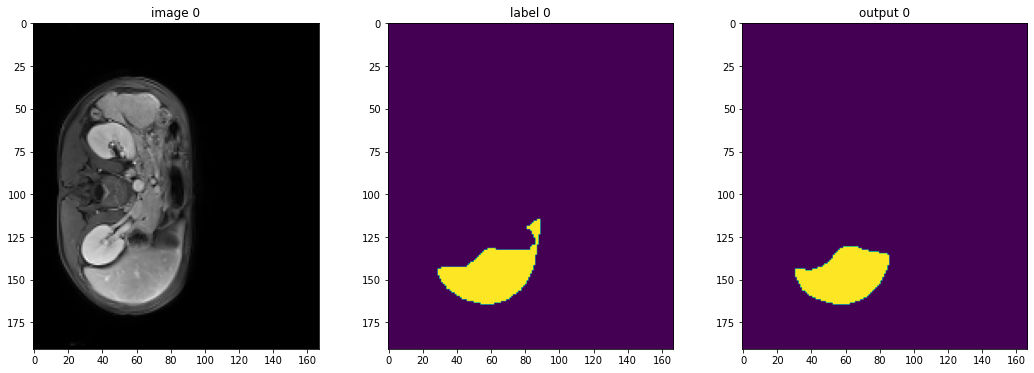

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00010_T1_PV_liver_segm.nii.gz


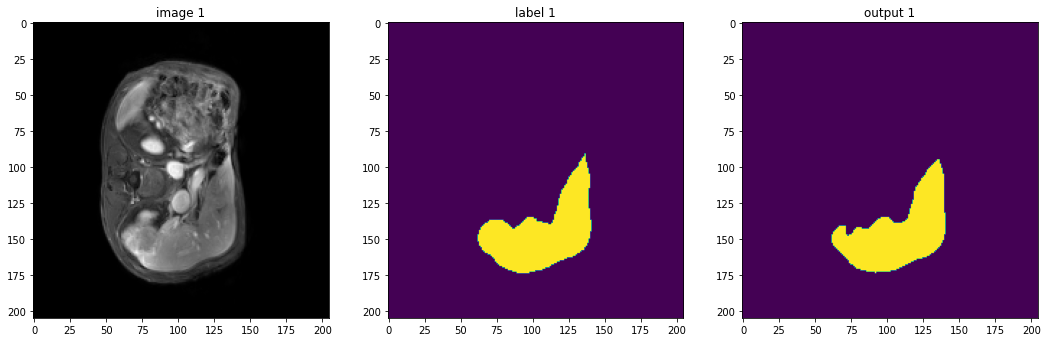

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00023_T1_PV_liver_segm.nii.gz


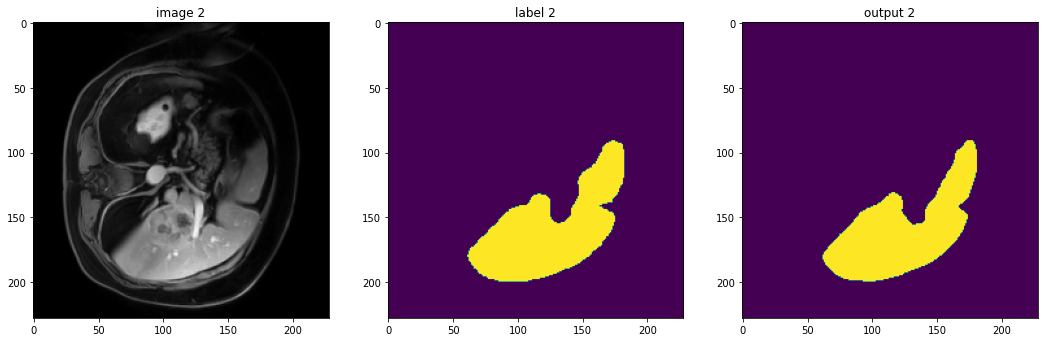

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00004_T1_PV_liver_segm.nii.gz


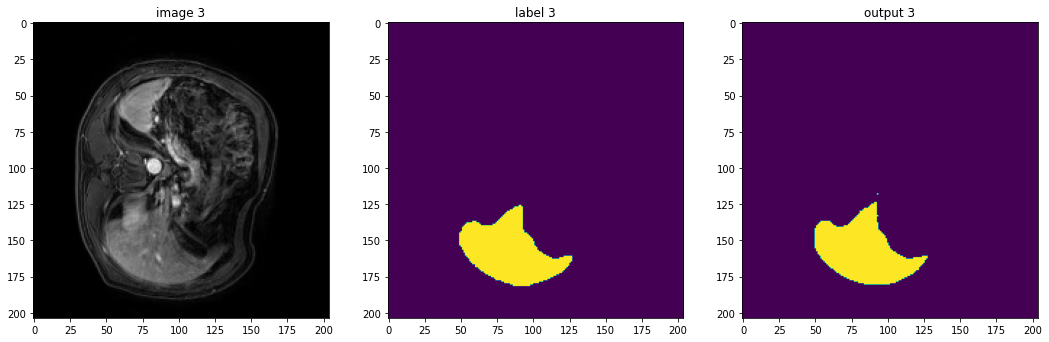

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00017_T1_PV_liver_segm.nii.gz


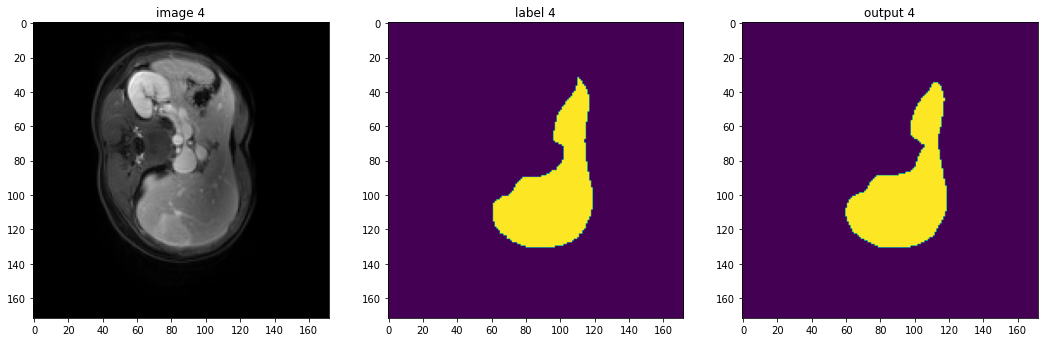

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00040_T1_PV_liver_segm.nii.gz


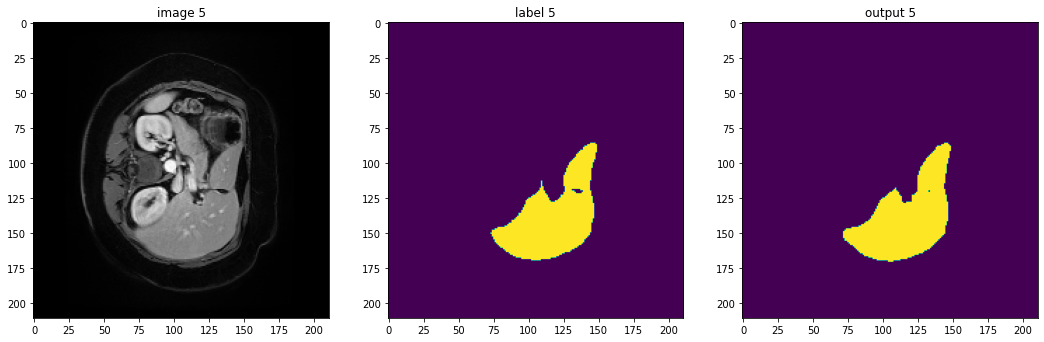

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00011_T1_PV_liver_segm.nii.gz


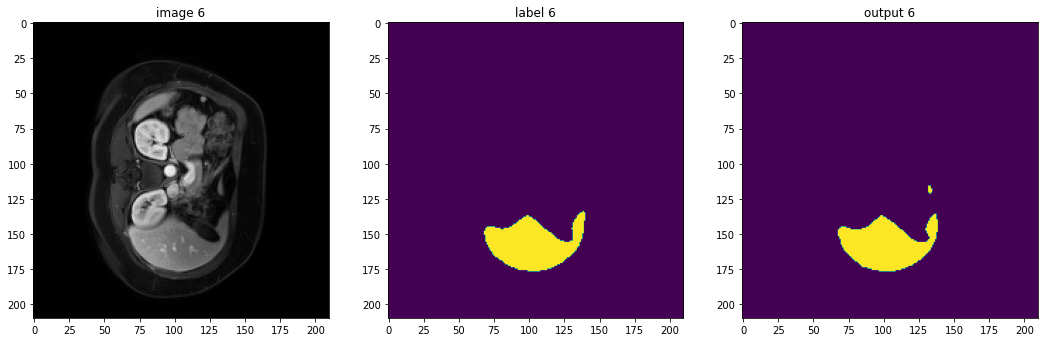

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00022_T1_PV_liver_segm.nii.gz


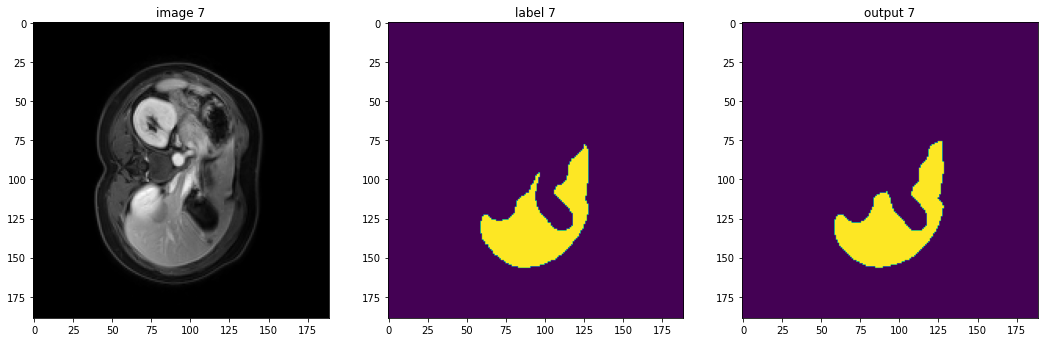

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00018_T1_PV_liver_segm.nii.gz


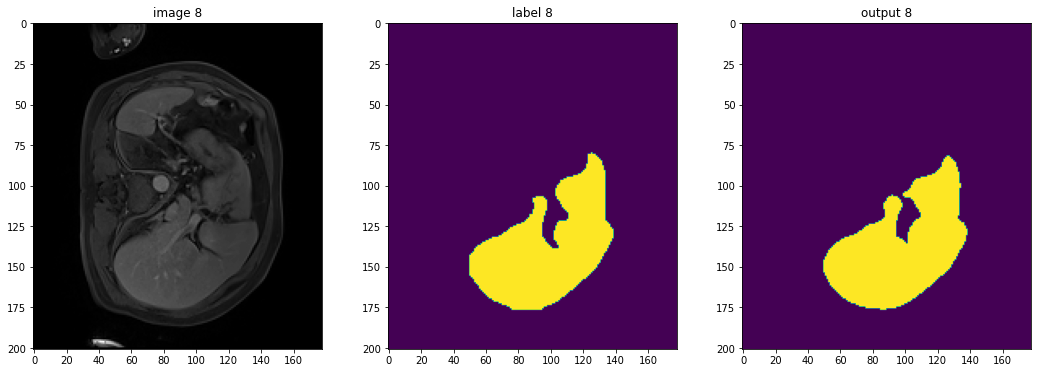

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00012_T1_PV_liver_segm.nii.gz


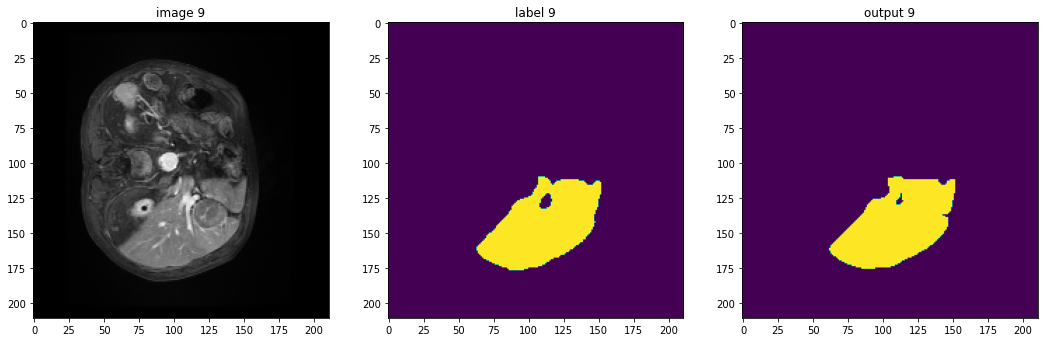

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00006_T1_PV_liver_segm.nii.gz


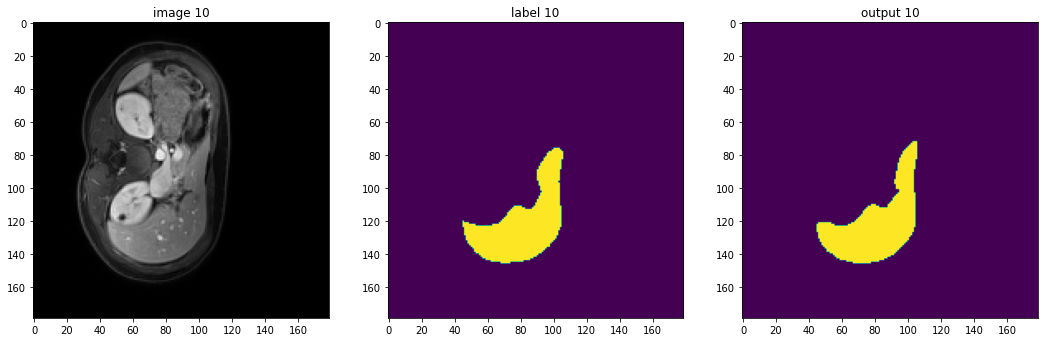

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00063_T1_PV_liver_segm.nii.gz


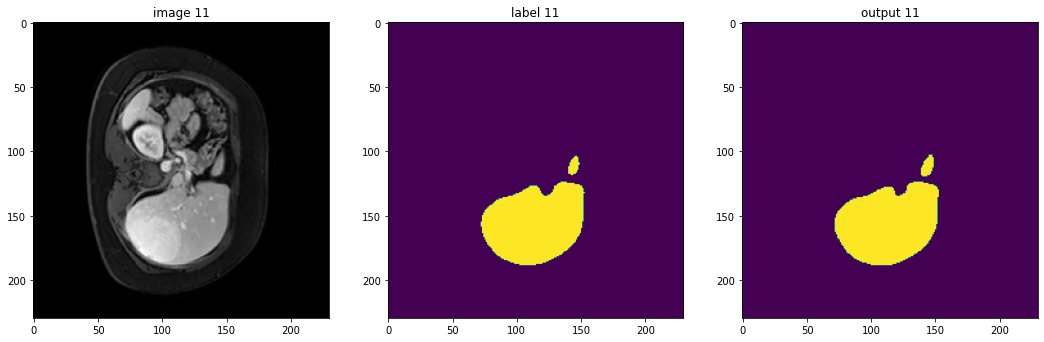

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00003_T1_PV_liver_segm.nii.gz


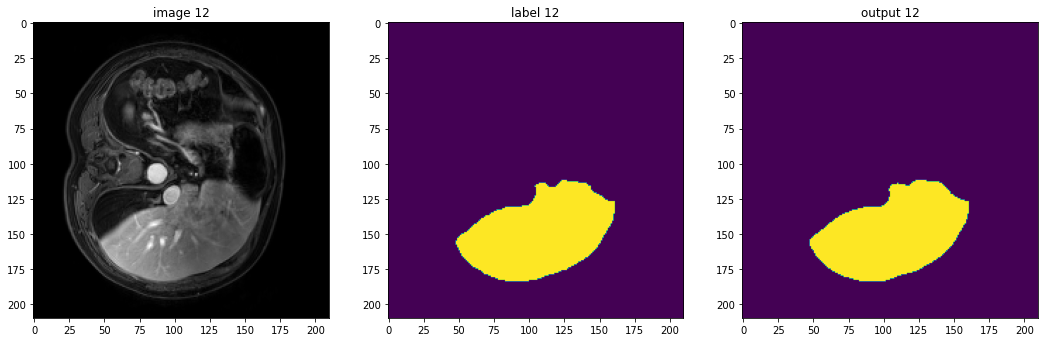

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00032_T1_PV_liver_segm.nii.gz


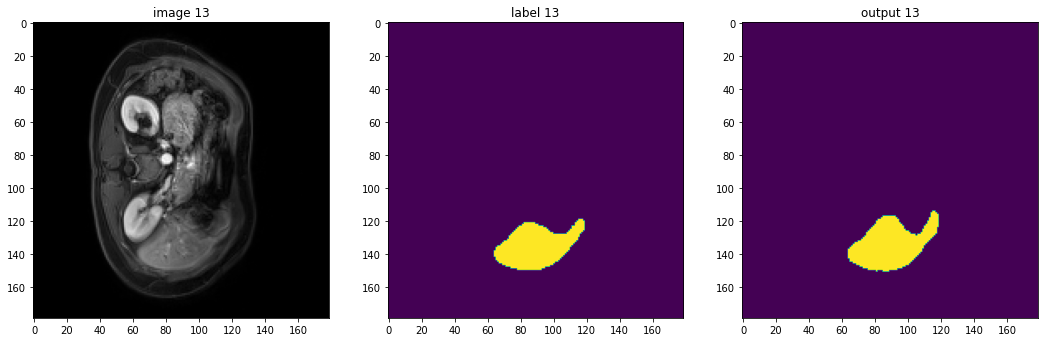

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00002_T1_PV_liver_segm.nii.gz


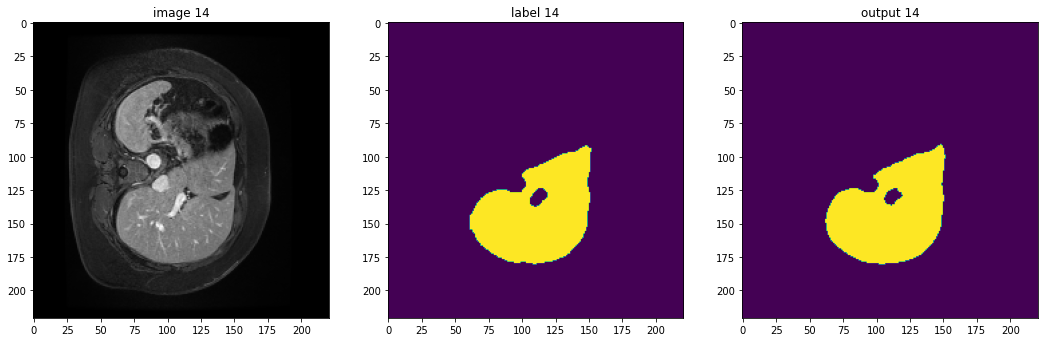

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00055_T1_PV_liver_segm.nii.gz


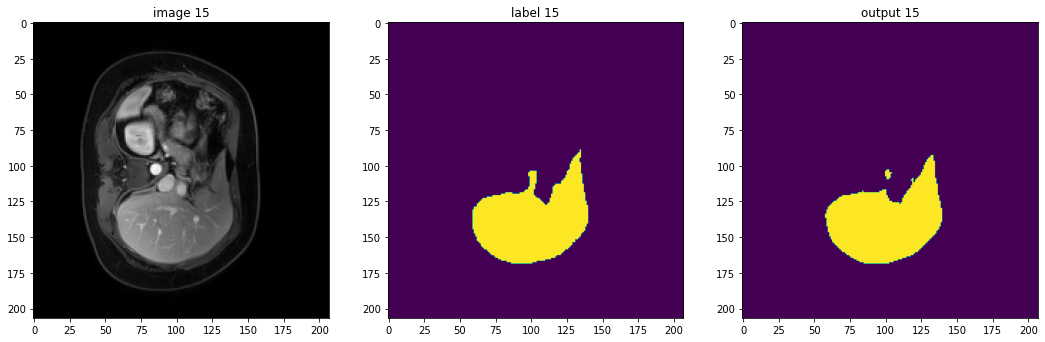

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00059_T1_PV_liver_segm.nii.gz


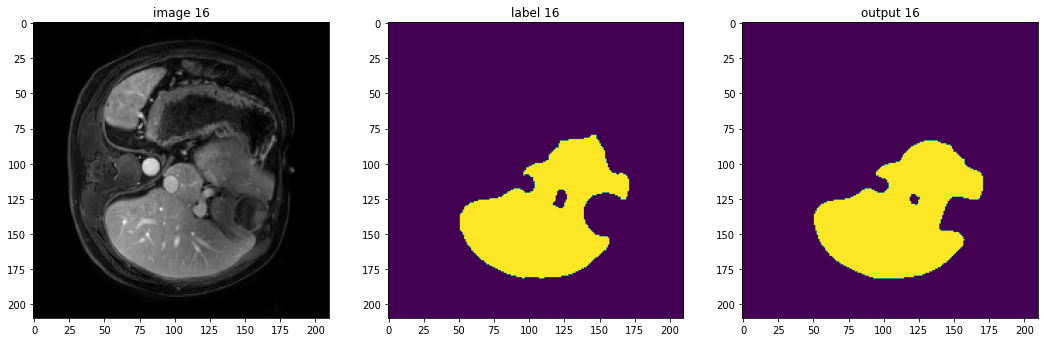

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00001_T1_PV_liver_segm.nii.gz


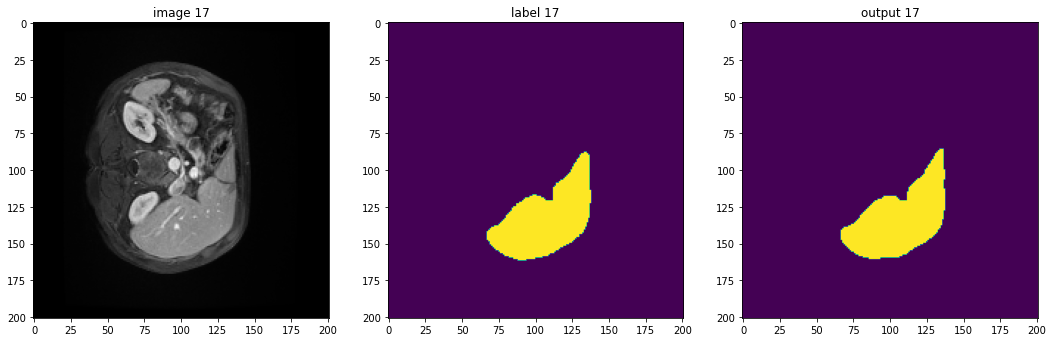

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00019_T1_PV_liver_segm.nii.gz


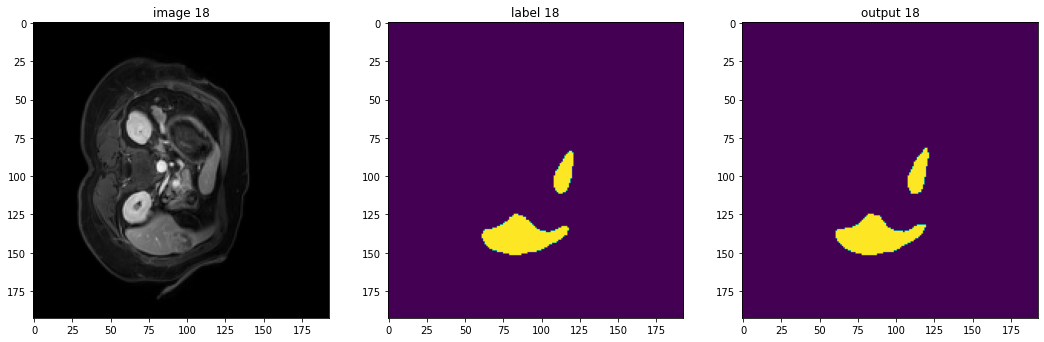

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00015_T1_PV_liver_segm.nii.gz


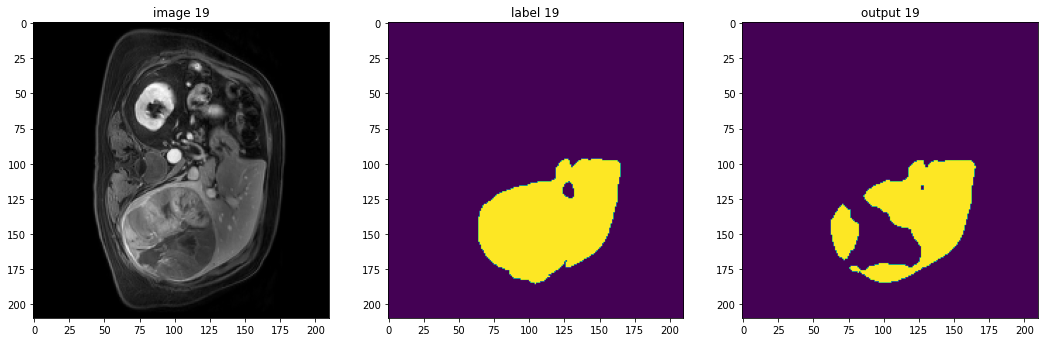

/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/ExternalValidation/00035_T1_PV_liver_segm.nii.gz


,DICE,POST_DICE,HD95,POST_HD95,MAD,POST_MAD,InferenceTime
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.955676,0.961609,33.692023,2.711356,5.757323,0.704979,0.005418
std,0.030705,0.031997,25.638223,3.448653,6.105330,0.698308,0.001882
min,0.830352,0.830352,1.732051,1.414214,0.648990,0.393897,0.003545
25%,0.955306,0.962603,3.596812,1.732051,2.828344,0.468514,0.003876
50%,0.961807,0.966552,40.418531,1.866025,3.699798,0.524563,0.004916
75%,0.966916,0.974410,49.680730,2.236068,7.186251,0.598196,0.006888
max,0.975659,0.982319,87.028731,17.233688,28.165277,3.606874,0.008978


In [37]:
# model inference
OUTPUT_PATH = r'ExternalValidation'

df_paris_results = evaluate(model=model, data_loader=paris_test_loader, plot_results = True, output_path=OUTPUT_PATH, filename_prefix_key='ACCESSION_ID') #, 
df_paris_results.describe()

In [38]:
for idx, row in  df_paris_results.iterrows():
    df_paris_results.loc[idx, 'ACCESSION_ID'] = str(row['PV'].split('/')[-2])



df_paris_master = pd.merge(df_paris, df_paris_results, on = 'ACCESSION_ID')

df_paris_master['GT-VOLUME'] = df_paris_master['SEGM'].apply(lambda x: calc_volume(x))
df_paris_master['Automated-VOLUME'] = df_paris_master['AUTOMATED-LIVER-SEGM'].apply(lambda x: calc_volume(x))


df_paris_master

,ACCESSION_ID,IMAGE,SEGM,PV,DICE,POST_DICE,HD95,POST_HD95,MAD,POST_MAD,InferenceTime,AUTOMATED-LIVER-SEGM,GT-VOLUME,Automated-VOLUME
0,00010,/tensor5/data1/mgross/Liver/Paris/00010/00010_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...,/tensor5/data1/mgross/Liver/Paris/00010/00010_...,0.958976,0.959233,3.741657,3.000000,1.115764,0.844088,0.008978,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1693.953050,1710.065848
1,00023,/tensor5/data1/mgross/Liver/Paris/00023/00023_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...,/tensor5/data1/mgross/Liver/Paris/00023/00023_...,0.961944,0.967408,42.201896,2.000000,5.269741,0.537363,0.006830,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1320.047598,1327.852720
2,00004,/tensor5/data1/mgross/Liver/Paris/00004/00004_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...,/tensor5/data1/mgross/Liver/Paris/00004/00004_...,0.946397,0.948924,25.709920,2.236068,2.559498,0.990483,0.005452,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,3082.032708,2821.166812
3,00017,/tensor5/data1/mgross/Liver/Paris/00017/00017_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...,/tensor5/data1/mgross/Liver/Paris/00017/00017_...,0.954006,0.961148,49.689033,2.236068,7.608042,0.648622,0.004697,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1429.493419,1471.987370
4,00040,/tensor5/data1/mgross/Liver/Paris/00040/00040_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...,/tensor5/data1/mgross/Liver/Paris/00040/00040_...,0.961671,0.965471,41.533119,2.236068,3.965751,0.531533,0.003545,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1340.485543,1338.384937
5,00011,/tensor5/data1/mgross/Liver/Paris/00011/00011_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...,/tensor5/data1/mgross/Liver/Paris/00011/00011_...,0.973327,0.975566,2.449490,1.732051,2.330531,0.487035,0.007062,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,2090.755354,2140.605661
6,00022,/tensor5/data1/mgross/Liver/Paris/00022/00022_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...,/tensor5/data1/mgross/Liver/Paris/00022/00022_...,0.965738,0.973341,49.487372,1.732051,7.659197,0.470077,0.003761,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1478.032226,1488.060454
7,00018,/tensor5/data1/mgross/Liver/Paris/00018/00018_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...,/tensor5/data1/mgross/Liver/Paris/00018/00018_...,0.964726,0.965697,2.000000,1.732051,2.095704,0.584031,0.008045,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1366.117901,1408.533566
8,00012,/tensor5/data1/mgross/Liver/Paris/00012/00012_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...,/tensor5/data1/mgross/Liver/Paris/00012/00012_...,0.963824,0.963906,3.000000,3.000000,0.648990,0.573293,0.008383,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1698.720883,1655.606015
9,00006,/tensor5/data1/mgross/Liver/Paris/00006/00006_...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...,/tensor5/data1/mgross/Liver/Paris/00006/00006_...,0.975556,0.976984,1.732051,1.414214,2.917959,0.413025,0.003892,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,1287.120176,1304.424324


In [40]:
df_paris_master.to_csv('PARISResultsVolumetryNetExperiment.csv', index = False)
df_paris_master = pd.read_csv('PARISResultsVolumetryNetExperiment.csv')

In [45]:
df_paris_master.POST_DICE.describe()

count    20.000000
mean      0.961609
std       0.031997
min       0.830352
25%       0.962603
50%       0.966552
75%       0.974410
max       0.982319
Name: POST_DICE, dtype: float64